# 10. Сборный проект 2. Анализ пользовательского поведения в мобильном приложении 

## Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
from scipy import stats as st
df= pd.read_csv( '/datasets/logs_exp.csv',sep='\t')
display(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


# Изучение и подготовка данных

In [2]:
df.info()
print('\nЧисло дубликатов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Число дубликатов: 413


In [3]:
df[df.duplicated()]

,EventName,DeviceIDHash,EventTimestamp,ExpId
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [4]:
#посмотрим количество пропусков
print(df.isna().sum())

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


In [5]:
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Изменение названий столбцов

In [6]:
df.columns=['event','user_id','event_time','gr']

In [7]:
df.head()

,event,user_id,event_time,gr
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Удалим дубликаты, создаем столбец даты, приведем столбец даты к формату даты и времени

In [8]:
#df=df.drop_duplicates() #были просмотрены дупликаты и принято решение не удалять их, так как в дубликаты вошли названия и повторяющиеся пользователи.
df['event_time']=pd.to_datetime(df['event_time'], unit='s')
df['date']  = df['event_time'].dt.date

In [9]:
df

,event,user_id,event_time,gr,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [10]:
len(df['event'])

244126

Всего 243713 событий 

In [11]:
df['user_id'].nunique() # В логе 7551 пользователей

7551

In [12]:
pp= round(len(df['event'])/df['user_id'].nunique())
pp


32

В среднем на пользователя приходится 32 события

Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [13]:
min(df['date']) #минимальная дата 

datetime.date(2019, 7, 25)

In [14]:
max(df['date']) #максимальная дата

datetime.date(2019, 8, 7)

Построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени.

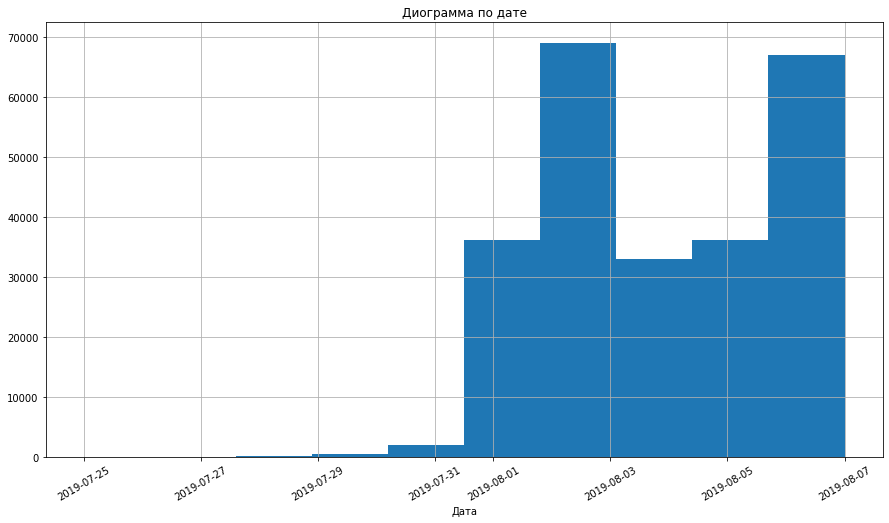

In [15]:
plt.figure(figsize=(15,8)) 
df['date'].hist()
plt.title('Диограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=30) 
plt.show()

Данные ранее 1 августа отсутствуют. Посмотрим столбчатую диаграмму от 1 августа.

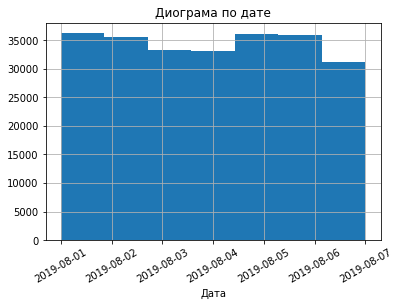

In [16]:
df['date']= pd.to_datetime(df['date'])
new_df= df.query('date>"2019-07-31"')
new_df['date'].hist(bins=7)
plt.title('Диограма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=30) 
plt.show()

In [17]:
old_df= df.query('date<="2019-07-31"')
print('Было потеряно', len(old_df), 'событий')

Было потеряно 2828 событий


In [18]:
t=0
for i in new_df:
    if i not in old_df['user_id'].unique():
        t+=1
print('Потеряно', t, 'устройств')

Потеряно 5 устройств


/tmp/ipykernel_108/2200404398.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i not in old_df['user_id'].unique():


Абсолютные потери: 2826 событий и 5 пользователей.

In [20]:
print("Было потеряно",round(len(old_df)/len(df)*100,1), '% событий')

Было потеряно 1.2 % событий


In [21]:
print("Было потеряно",round(t/df['user_id'].nunique()*100,1), '% устройств')

Было потеряно 0.1 % устройств


Было потеряно 2826 событий и 5 пользователей или 1.2 % событий и  0.1 % пользователей. Это немного, их можно удалить.

In [22]:
new_df

,event,user_id,event_time,gr,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Проверим, есть ли пользователи во всех трёх экспериментальных групп.

In [23]:
new_df['gr'].value_counts()

248    84726
246    79425
247    77147
Name: gr, dtype: int64

В каждой группе 70-80 тысяч человек.

# Шаг 4. Изучите воронку событий

In [24]:
new_df['event'].value_counts()

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

В логах есть 5 видов событий. Самое частое событие - MainScreenAppear( появление главного экрана), затем по популярности идут OffersScreenAppear(появление предложения о товаре), CartScreenAppear (переход к корзине) и PaymentScreenSuccessful( экран оплаты). Самое редкое событие - это Tutorial.

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [25]:
ev=new_df.pivot_table(index='event', values='user_id', aggfunc='nunique').sort_values('user_id',ascending=False)

In [26]:
ev['percent']=(ev['user_id']/len(new_df['user_id'].unique()))*100


In [27]:
ev

,user_id,percent
event,,
MainScreenAppear,7419,98.473586
OffersScreenAppear,4593,60.963632
CartScreenAppear,3734,49.561986
PaymentScreenSuccessful,3539,46.973719
Tutorial,840,11.149456


Text(0.5, 1.0, 'Соотношение событий по количеству пользователей')

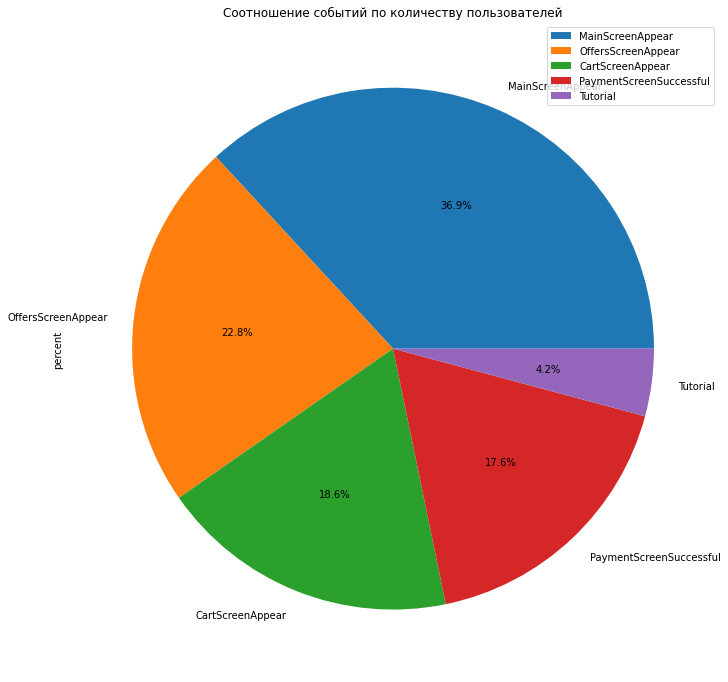

In [28]:
# Построим диаграмму
ev.plot( y='percent', kind = 'pie', autopct='%1.1f%%', figsize=(12, 12))
plt.title('Соотношение событий по количеству пользователей')

Построим столбчатую диаграмму воронки.

Text(0.5, 1.0, 'Соотношение событий по количеству пользователей')

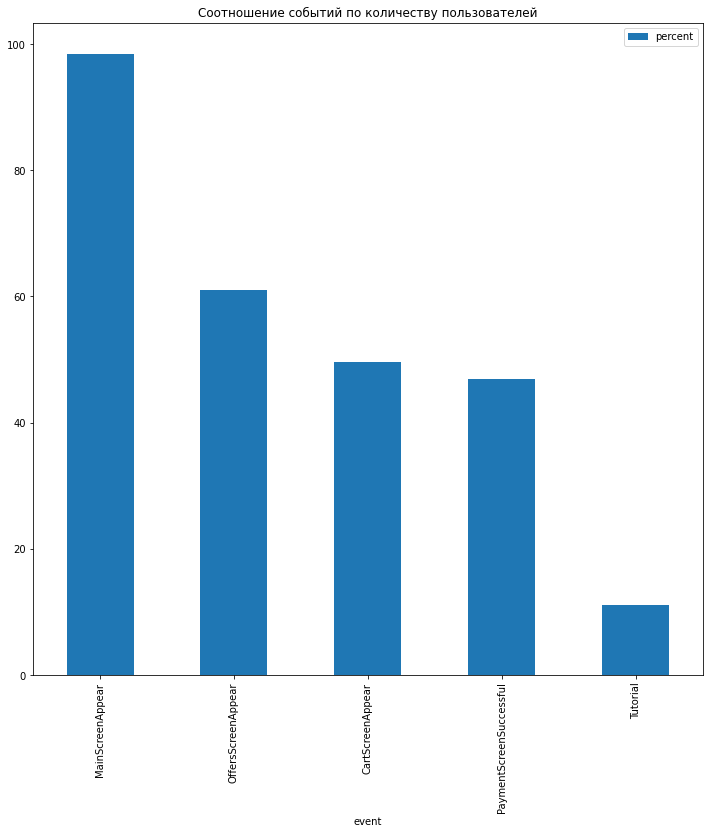

In [29]:
ev.plot( y='percent', kind = 'bar', figsize=(12, 12))
plt.title('Соотношение событий по количеству пользователей')

Tutorial - наиболее редкое событие. Его можно удалить из набора данных.

In [30]:
ev=ev.query('event!="Tutorial"')
ev

,user_id,percent
event,,
MainScreenAppear,7419,98.473586
OffersScreenAppear,4593,60.963632
CartScreenAppear,3734,49.561986
PaymentScreenSuccessful,3539,46.973719


MainScreenAppear(появление главного экрана) - самое популярное событие, за ним идут OffersScreenAppear(предложение о товаре), CartScreenAppear(переход к корзине) и PaymentScreenSuccessful(экран с оплатой). 

Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [31]:
#сделаем это с помощью shift.
ev['shift']= ev['user_id'].shift()


/tmp/ipykernel_108/1327005097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev['shift']= ev['user_id'].shift()


In [32]:
ev

,user_id,percent,shift
event,,,
MainScreenAppear,7419,98.473586,NaN
OffersScreenAppear,4593,60.963632,7419.0
CartScreenAppear,3734,49.561986,4593.0
PaymentScreenSuccessful,3539,46.973719,3734.0


In [33]:
ev['conversion']= round(ev['user_id']/ev['shift']*100,1) # конверсия со сдвигом

/tmp/ipykernel_108/427388514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev['conversion']= round(ev['user_id']/ev['shift']*100,1) # конверсия со сдвигом


In [34]:
ev.drop(columns = 'shift', axis=1, inplace = True)#удаляем столбец

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [35]:
ev

,user_id,percent,conversion
event,,,
MainScreenAppear,7419,98.473586,NaN
OffersScreenAppear,4593,60.963632,61.9
CartScreenAppear,3734,49.561986,81.3
PaymentScreenSuccessful,3539,46.973719,94.8


До успешной оплаты доходят только 46% пользователей. Возможно, причина в экране, показывающем предложение. Возможно, имеют место проблемы с UX-дизайном, его нужно доработать.

Построила стобчатую диаграмму.

# Шаг 5. Изучите результаты эксперимента

In [36]:
#Сделаем таблицу с количествои пользователей в группах
data_groups = new_df.pivot_table(index='gr',values='user_id',aggfunc='nunique')
display(data_groups)

,user_id
gr,
246,2484
247,2513
248,2537


Проверим, принадлежит ли каждый пользователь только одной группе

In [37]:
group_1a= new_df.query('gr=="246"')['user_id']
group_2a= new_df.query('gr=="247"')['user_id']
group_1b= new_df.query('gr=="248"')['user_id']

In [38]:
coiaa= group_2a[group_2a.isin(group_1a)]
display(coiaa.nunique())

0

In [39]:
coia1b= group_1b[group_1b.isin(group_1a)]
display(coia1b.nunique())

0

In [40]:
coia2b= group_1b[group_1b.isin(group_2a)]
display(coia2b.nunique())

0

Каждый пользователь принадлежит только одной группе.

In [41]:
#Создадим таблицу с информацией для каждой группы
user_per_event= new_df.pivot_table(index='gr',columns='event', values= 'user_id', aggfunc= 'nunique').reset_index()
user_per_event

event,gr,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


In [42]:
#добавим количество пользователей в каждой в группе.
users_count = new_df.groupby('gr')['user_id'].nunique()

In [43]:
user_per_event['users_count'] = user_per_event['gr'].apply(lambda x: users_count.loc[x])
user_per_event = user_per_event.set_index('gr')
user_per_event

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,users_count
gr,,,,,,
246,1266,2450,1542,1200,278,2484
247,1238,2476,1520,1158,283,2513
248,1230,2493,1531,1181,279,2537


In [44]:
user_per_event.iloc[0]['CartScreenAppear']

1266

In [45]:
# Создадим списки с группой А, А1 и Б.
groupA=[ user_per_event.iloc[0][5],user_per_event.iloc[0][0],user_per_event.iloc[0][1],user_per_event.iloc[0][2],user_per_event.iloc[0][3]]

In [46]:
#объединенная группа А
AA= [user_per_event.iloc[0][5]+user_per_event.iloc[1][5], user_per_event.iloc[0][0]+user_per_event.iloc[1][0],user_per_event.iloc[0][1]+user_per_event.iloc[1][1],user_per_event.iloc[0][2]+user_per_event.iloc[1][2],user_per_event.iloc[0][3]+user_per_event.iloc[1][3]]

In [47]:
AA

[4997, 2504, 4926, 3062, 2358]

In [48]:
groupA1=[ user_per_event.iloc[1][5],user_per_event.iloc[1][0],user_per_event.iloc[1][1],user_per_event.iloc[1][2],user_per_event.iloc[1][3]]
groupB=[ user_per_event.iloc[2][5],user_per_event.iloc[2][0],user_per_event.iloc[2][1],user_per_event.iloc[2][2],user_per_event.iloc[2][3]]

Функция со статистическим тестом.

In [49]:
def st_test(event, group1, group2):

    alpha = .05 # критический уровень статистической значимости

    # пропорция успехов в первой группе:
    p1 = group1[event]/group1[0]

    # пропорция успехов во второй группе:
    p2 = group2[event]/group2[0]

    # пропорция успехов в комбинированном датасете:
    p_combined = (group1[event] + group2[event]) / (group1[0] + group2[0])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group1[0] + 1/group2[0]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Проверим, равны ли группы А по каждому из событий.

In [50]:
st_test(1, groupA, groupA1)
st_test(2, groupA, groupA1)
st_test(3, groupA, groupA1)
st_test(4, groupA, groupA1)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистических различий между двумя группами А не обнаружено. Мы можем сравнить обе группы с группой В. 

In [51]:
# теперь сравним объединенную группу А с группой В.
st_test(1, AA, groupB)
st_test(2, AA, groupB)
st_test(3, AA, groupB)
st_test(4, AA, groupB)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравним группы 246 и 248 по каждому из событий.

In [52]:
st_test(1, groupA, groupB)
st_test(2, groupA, groupB)
st_test(3, groupA, groupB)
st_test(4, groupA, groupB)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравним группы 247 и 248 по каждому из событий.

In [53]:
st_test(1, groupA1, groupB)
st_test(2, groupA1, groupB)
st_test(3, groupA1, groupB)
st_test(4, groupA1, groupB)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы выбрали 0,05% за уровень статистической значимости. 